In [2]:
# Prévision des besoins en consommation électrique des bâtiments

In [4]:
# Chargement des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

In [6]:
# Configuration de l'environnement
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [10]:
# Chargement des données 2015
donnees_2015 = pd.read_csv("2015-building-energy-benchmarking.csv", low_memory=False)
print(f"Dimensions du jeu de données: {donnees_2015.shape}")

Dimensions du jeu de données: (3340, 47)


In [12]:
# Chargement des données 2016
donnees_2016 = pd.read_csv("2016-building-energy-benchmarking.csv", low_memory=False)
print(f"Dimensions du jeu de données: {donnees_2015.shape}")

Dimensions du jeu de données: (3340, 47)


In [20]:
try:
    donnees_2016 = pd.read_csv("../data/2016-building-energy-benchmarking.csv", low_memory=False)
    print(f"Dimensions du jeu de données 2016: {donnees_2016.shape}")
    donnees_2016_disponibles = True
except FileNotFoundError:
    print("Avertissement: Fichier 2016 non trouvé")
    donnees_2016_disponibles = False

Avertissement: Fichier 2016 non trouvé


In [22]:
# Ajouter une colonne d'année pour identifier la source
donnees_2015['Annee'] = 2015
if donnees_2016_disponibles:
    donnees_2016['Annee'] = 2016

In [28]:
# Vérifier si les colonnes sont identiques entre les deux jeux de données
if donnees_2016_disponibles:
    colonnes_communes = set(donnees_2015.columns).intersection(set(donnees_2016.columns))
    print(f"Nombre de colonnes communes: {len(colonnes_communes)}")

  # Fusion des deux jeux de données avec les colonnes communes
    donnees_complete = pd.concat([
        donnees_2015[list(colonnes_communes)],
        donnees_2016[list(colonnes_communes)]
    ], axis=0, ignore_index=True)
    
    print(f"Dimensions du jeu de données combiné: {donnees_complete.shape}")
else:
    donnees_complete = donnees_2015.copy()


In [30]:
# Affichage des premières lignes pour comprendre la structure
donnees_complete.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Annee
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.00,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,65.00,78.90,80.30,173.50,175.10,6981428.00,7097539.00,2023032.00,1080307.00,3686160.00,12724.00,1272388.00,0.00,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081,2015
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,51.00,94.40,99.00,191.30,195.20,8354235.00,8765788.00,0.00,1144563.00,3905411.00,44490.00,4448985.00,0.00,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.00,NaN,31.00,18081,2015
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.00,Parking,100000.00,Swimming Pool,0.00,NaN,18.00,96.60,99.70,242.70,246.50,73130656.00,75506272.00,19660404.00,14583930.00,49762435.00,37099.00,3709900.00,0.00,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,18081,2015
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.00,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,1.00,460.40,462.50,636.30,643.20,28229320.00,28363444.00,23458518.00,811521.00,2769023.00,20019.00,2001894.00,0.00,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.00,NaN,31.00,18081,2015
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.00,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,67.00,120.10,122.10,228.80,227.10,14829099.00,15078243.00,0.00,1777841.00,6066245.00,87631.00,8763105.00,0.00,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.00,NaN,31.00,19576,2015


In [32]:
# Fonction pour nettoyer les colonnes numériques
def nettoyer_colonne_numerique(colonne):
    if colonne.dtype == 'object':
        return pd.to_numeric(colonne.astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')
    return colonne

In [34]:
# Liste des colonnes à convertir
colonnes_numeriques = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
    'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore'
]


In [36]:
# Application de la conversion
for col in colonnes_numeriques:
    if col in donnees_complete.columns:
        donnees_complete[col] = nettoyer_colonne_numerique(donnees_complete[col])

In [38]:
# Analyse des valeurs manquantes
valeurs_manquantes = pd.DataFrame({
    'Nombre_NA': donnees_complete.isnull().sum(),
    'Pourcentage_NA': (donnees_complete.isnull().sum() / len(donnees_complete) * 100).round(2)
})
valeurs_manquantes = valeurs_manquantes.sort_values('Pourcentage_NA', ascending=False)
print(valeurs_manquantes[valeurs_manquantes['Nombre_NA'] > 0].head(20))

                                 Nombre_NA  Pourcentage_NA
Comment                               3327           99.61
Outlier                               3256           97.49
YearsENERGYSTARCertified              3230           96.71
City Council Districts                3127           93.62
2010 Census Tracts                    3116           93.29
ThirdLargestPropertyUseTypeGFA        2780           83.23
ThirdLargestPropertyUseType           2780           83.23
SecondLargestPropertyUseTypeGFA       1781           53.32
SecondLargestPropertyUseType          1781           53.32
ENERGYSTARScore                        780           23.35
LargestPropertyUseType                 136            4.07
LargestPropertyUseTypeGFA              136            4.07
ListOfAllPropertyUseTypes              127            3.80
SourceEUI(kBtu/sf)                      10            0.30
SiteEUIWN(kBtu/sf)                      10            0.30
OtherFuelUse(kBtu)                      10            0.

In [40]:
# Suppression des colonnes avec plus de 50% de valeurs manquantes
colonnes_trop_na = valeurs_manquantes[valeurs_manquantes['Pourcentage_NA'] > 50].index.tolist()
donnees_propres = donnees_complete.drop(columns=colonnes_trop_na)
print(f"Nombre de colonnes restantes: {donnees_propres.shape[1]}")

Nombre de colonnes restantes: 39


In [42]:
# Comparaison des statistiques entre 2015 et 2016 si disponible
if donnees_2016_disponibles:
    variables_comparaison = ['TotalGHGEmissions', 'SiteEUI(kBtu/sf)', 'ENERGYSTARScore']
    variables_dispo = [col for col in variables_comparaison if col in donnees_propres.columns]
    
    # Statistiques descriptives par année
    stats_par_annee = donnees_propres.groupby('Annee')[variables_dispo].describe()
    print("\nStatistiques descriptives par année:")
    print(stats_par_annee)
    
    # Comparaison visuelle des distributions par année
    plt.figure(figsize=(15, 5))
    
    for i, var in enumerate(variables_dispo):
        plt.subplot(1, len(variables_dispo), i+1)
        sns.boxplot(x='Annee', y=var, data=donnees_propres)
        plt.title(f'Comparaison de {var} par année')
        plt.xlabel('Année')
        plt.ylabel(var)
    
    plt.tight_layout()
    plt.show()
    
    # Test statistique pour vérifier si les différences sont significatives
    for var in variables_dispo:
        donnees_2015_var = donnees_propres[donnees_propres['Annee'] == 2015][var].dropna()
        donnees_2016_var = donnees_propres[donnees_propres['Annee'] == 2016][var].dropna()
        
        t_stat, p_value = stats.ttest_ind(donnees_2015_var, donnees_2016_var, equal_var=False)
        print(f"\nTest-t pour {var}:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Différence significative (p<0.05): {'Oui' if p_value < 0.05 else 'Non'}")

In [46]:
# Examinons les colonnes disponibles
print("\nAperçu des 10 premières colonnes:")
print(list(donnees_2015.columns[:10]))
print("\nAperçu des colonnes contenant 'GHG' ou 'Emissions':")
colonnes_ghg = [col for col in donnees_2015.columns if 'GHG' in col or 'Emissions' in col]
print(colonnes_ghg)
print("\nAperçu des colonnes contenant 'EUI':")
colonnes_eui = [col for col in donnees_2015.columns if 'EUI' in col]
print(colonnes_eui)


Aperçu des 10 premières colonnes:
['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt']

Aperçu des colonnes contenant 'GHG' ou 'Emissions':
['GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']

Aperçu des colonnes contenant 'EUI':
['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']


In [48]:
# Après avoir identifié les noms exacts, utilisez les noms corrects des colonnes
# Remplacez 'TotalGHGEmissions' par le nom réel dans votre jeu de données
# Par exemple: 'GHGEmissions(MetricTonsCO2e)' ou 'Total GHG Emissions (MTCO2e)'

In [50]:
# Fonction pour vérifier si une colonne existe et obtenir son nom même avec des variantes mineures
def trouver_colonne_similaire(df, nom_partiel):
    colonnes_similaires = [col for col in df.columns if nom_partiel.lower() in col.lower()]
    if colonnes_similaires:
        return colonnes_similaires[0]  # Retourne la première correspondance
    return None

In [52]:
# Recherche des noms de colonnes pour les émissions GHG et EUI
col_ghg = trouver_colonne_similaire(donnees_2015, 'GHG')
col_eui = trouver_colonne_similaire(donnees_2015, 'EUI')


In [54]:
print(f"\nColonne pour les émissions GHG: {col_ghg}")
print(f"Colonne pour l'intensité énergétique EUI: {col_eui}")


Colonne pour les émissions GHG: GHGEmissions(MetricTonsCO2e)
Colonne pour l'intensité énergétique EUI: SiteEUI(kBtu/sf)


In [58]:
# Conversion des types de données
def nettoyer_colonne_numerique(df, colonne):
    if colonne in df.columns:
        if df[colonne].dtype == 'object':
            # Suppression des caractères non numériques
            df[colonne] = pd.to_numeric(df[colonne].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')
    return df

In [60]:
# Ajout des colonnes GHG et EUI identifiées
if col_ghg:
    colonnes_numeriques.append(col_ghg)
if col_eui:
    colonnes_numeriques.append(col_eui)


In [62]:
# Application de la conversion
for col in colonnes_numeriques:
    donnees_2015 = nettoyer_colonne_numerique(donnees_2015, col)

In [64]:
# Création d'une copie de travail
donnees_propres = donnees_2015.copy()

In [70]:
# Création des variables transformées logarithmiques avec vérification d'existence des colonnes
# Utiliser les noms de colonnes corrects identifiés précédemment
if col_ghg and col_ghg in donnees_propres.columns:
    donnees_propres['Log_GHG_Emissions'] = np.log1p(donnees_propres[col_ghg])
    print(f"Variable Log_GHG_Emissions créée à partir de {col_ghg}")
else:
    print("Attention: Colonne pour les émissions GHG non trouvée ou supprimée")

if col_eui and col_eui in donnees_propres.columns:
    donnees_propres['Log_SiteEUI'] = np.log1p(donnees_propres[col_eui])
    print(f"Variable Log_SiteEUI créée à partir de {col_eui}")
else:
    print("Attention: Colonne pour l'intensité énergétique EUI non trouvée ou supprimée")


Variable Log_GHG_Emissions créée à partir de GHGEmissions(MetricTonsCO2e)
Variable Log_SiteEUI créée à partir de SiteEUI(kBtu/sf)


In [72]:
# Visualisations des distributions (si les colonnes existent)
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

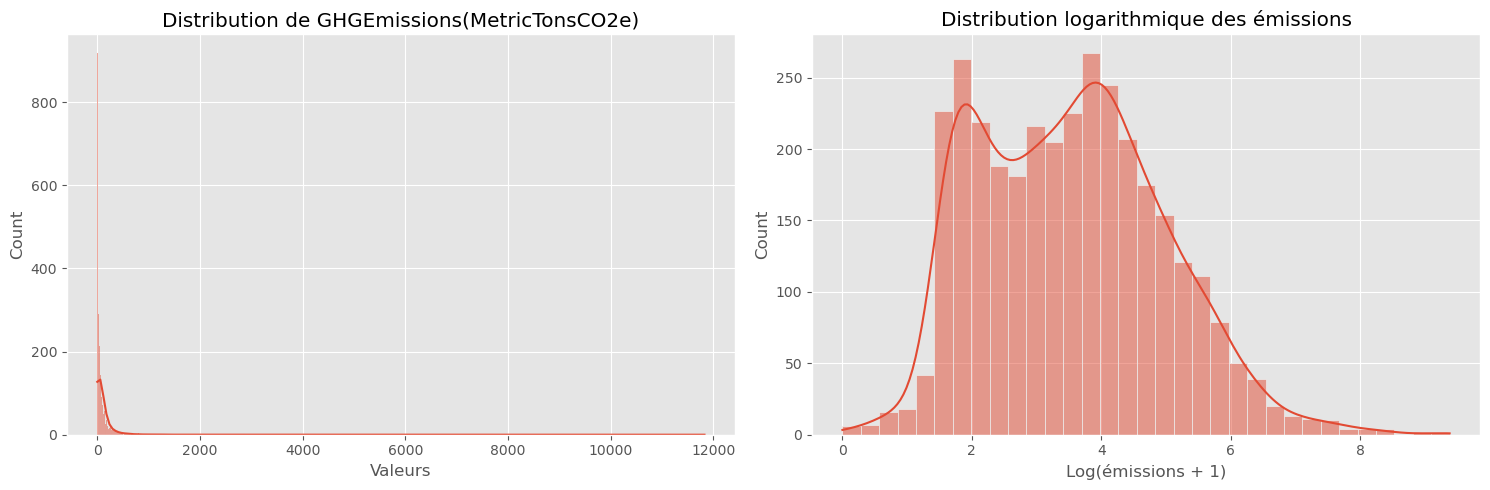

In [74]:
# Distribution des émissions GHG
if col_ghg and col_ghg in donnees_propres.columns:
    plt.subplot(1, 2, 1)
    sns.histplot(donnees_propres[col_ghg].dropna(), kde=True)
    plt.title(f'Distribution de {col_ghg}')
    plt.xlabel('Valeurs')

    # Distribution transformée
    if 'Log_GHG_Emissions' in donnees_propres.columns:
        plt.subplot(1, 2, 2)
        sns.histplot(donnees_propres['Log_GHG_Emissions'].dropna(), kde=True)
        plt.title('Distribution logarithmique des émissions')
        plt.xlabel('Log(émissions + 1)')

plt.tight_layout()
plt.show()

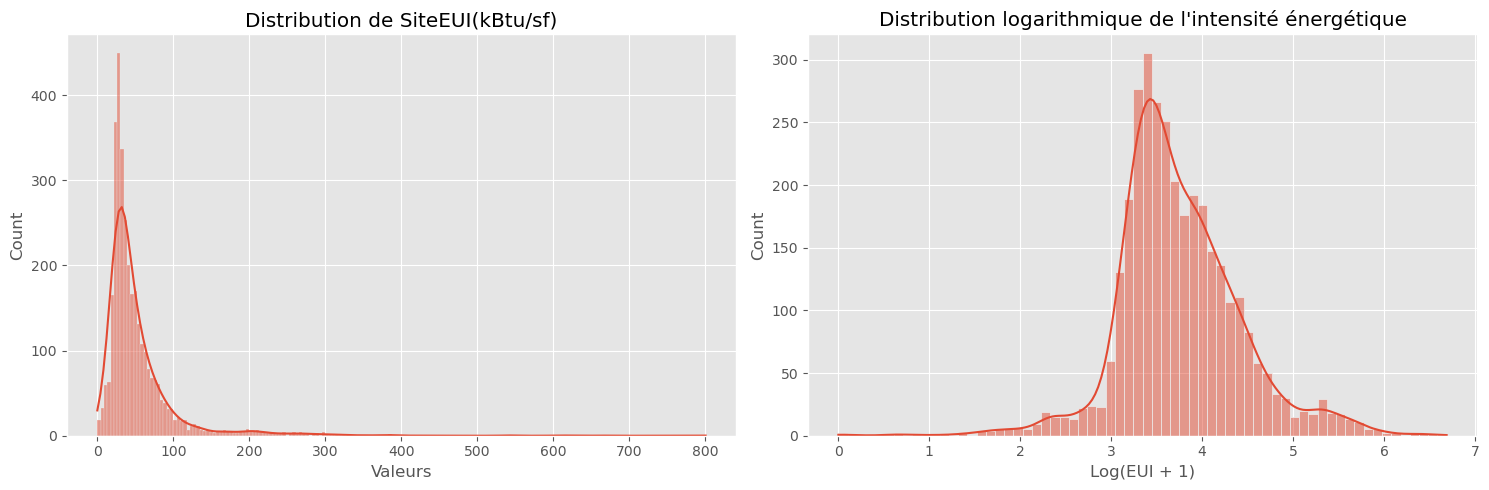

In [76]:
# Analyse de l'intensité énergétique
if col_eui and col_eui in donnees_propres.columns:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(donnees_propres[col_eui].dropna(), kde=True)
    plt.title(f'Distribution de {col_eui}')
    plt.xlabel('Valeurs')
    
    # Distribution transformée
    if 'Log_SiteEUI' in donnees_propres.columns:
        plt.subplot(1, 2, 2)
        sns.histplot(donnees_propres['Log_SiteEUI'].dropna(), kde=True)
        plt.title('Distribution logarithmique de l\'intensité énergétique')
        plt.xlabel('Log(EUI + 1)')
    
    plt.tight_layout()
    plt.show()

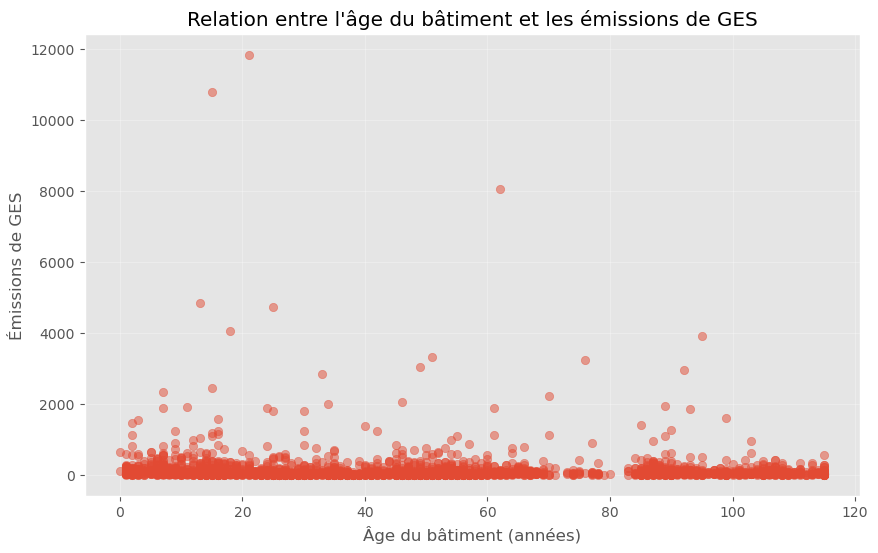

In [78]:
# Création d'une variable d'âge du bâtiment
if 'YearBuilt' in donnees_propres.columns:
    donnees_propres['Age_Batiment'] = 2015 - donnees_propres['YearBuilt']
    
    # Analyse de la relation entre l'âge et les émissions de GES
    if col_ghg and col_ghg in donnees_propres.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(donnees_propres['Age_Batiment'], donnees_propres[col_ghg], alpha=0.5)
        plt.title('Relation entre l\'âge du bâtiment et les émissions de GES')
        plt.xlabel('Âge du bâtiment (années)')
        plt.ylabel('Émissions de GES')
        plt.grid(True, alpha=0.3)
        plt.show()

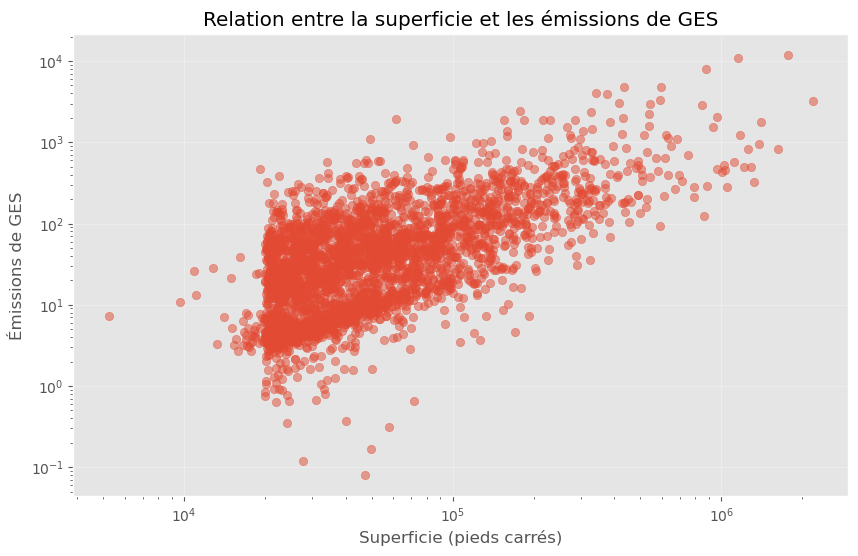

Corrélation entre superficie et émissions: 0.5536


In [80]:
# Analyse de la relation entre la taille du bâtiment et les émissions
if 'PropertyGFABuilding(s)' in donnees_propres.columns and col_ghg and col_ghg in donnees_propres.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(donnees_propres['PropertyGFABuilding(s)'], donnees_propres[col_ghg], alpha=0.5)
    plt.title('Relation entre la superficie et les émissions de GES')
    plt.xlabel('Superficie (pieds carrés)')
    plt.ylabel('Émissions de GES')
    plt.xscale('log')  # Échelle logarithmique pour mieux visualiser
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calcul et affichage de la corrélation
    correlation = donnees_propres['PropertyGFABuilding(s)'].corr(donnees_propres[col_ghg])
    print(f"Corrélation entre superficie et émissions: {correlation:.4f}")

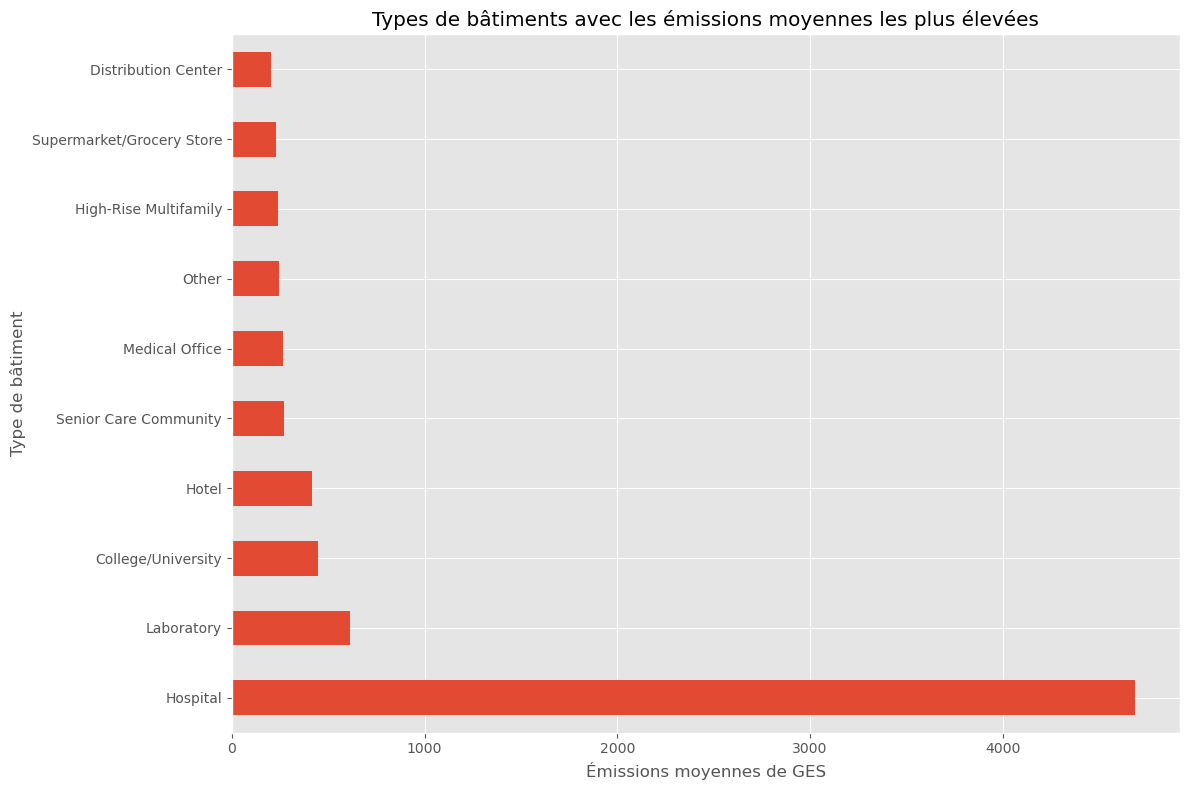

In [82]:
# Analyse des types de bâtiments si disponible
if 'PrimaryPropertyType' in donnees_propres.columns and col_ghg and col_ghg in donnees_propres.columns:
    # Calcul des émissions moyennes par type de bâtiment
    emissions_par_type = donnees_propres.groupby('PrimaryPropertyType')[col_ghg].mean().sort_values(ascending=False)
    
    # Visualisation des 10 types avec les émissions les plus élevées
    plt.figure(figsize=(12, 8))
    emissions_par_type.head(10).plot(kind='barh')
    plt.title('Types de bâtiments avec les émissions moyennes les plus élevées')
    plt.xlabel('Émissions moyennes de GES')
    plt.ylabel('Type de bâtiment')
    plt.tight_layout()
    plt.show()



Modélisation des émissions de GES
Lignes après filtrage des NaN: 3322 sur 3340
Performance du modèle linéaire:
RMSE: 293.49
R²: 0.2186

Importance des variables dans le modèle linéaire:
                 Variable         Coefficient
1               YearBuilt -425685570808576.69
2            Age_Batiment -425685570808557.44
0  PropertyGFABuilding(s)              298.97
3          NumberofFloors              -94.95
4       NumberofBuildings              -12.13

Performance des différents modèles (R²):
Régression Linéaire: 0.2186
Ridge: 0.2187
Lasso: 0.2188
Random Forest: -0.0843


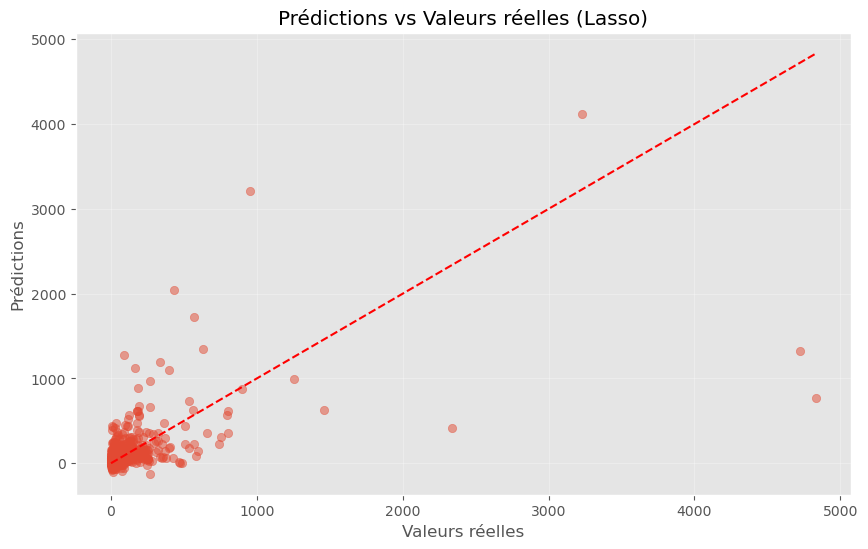

In [88]:
# Préparation des données pour la modélisation (si les colonnes cibles existent)
if col_ghg and col_ghg in donnees_propres.columns:
    # Sélection des colonnes pour la modélisation
    colonnes_modele = [
        'PropertyGFABuilding(s)', 'YearBuilt', 'Age_Batiment',
        'NumberofFloors', 'NumberofBuildings'
    ]
    
    # Filtrer pour ne garder que les colonnes disponibles
    colonnes_modele = [col for col in colonnes_modele if col in donnees_propres.columns]
    
    # Vérifier s'il y a assez de variables pour la modélisation
    if len(colonnes_modele) >= 3:
        print("\nModélisation des émissions de GES")
        
        # CORRECTION : Filtrer les lignes avec des valeurs NaN avant de créer X et y
        donnees_filtrees = donnees_propres.dropna(subset=colonnes_modele + [col_ghg])
        print(f"Lignes après filtrage des NaN: {len(donnees_filtrees)} sur {len(donnees_propres)}")
        
        # Préparation des ensembles d'entraînement et de test
        X = donnees_filtrees[colonnes_modele]
        y = donnees_filtrees[col_ghg]
        
        # Division en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Standardisation des caractéristiques
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entraînement d'un modèle de régression linéaire
        modele_lin = LinearRegression()
        modele_lin.fit(X_train_scaled, y_train)
        
        # Prédictions et évaluation
        predictions = modele_lin.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        
        print(f"Performance du modèle linéaire:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.4f}")
        
        # Affichage des coefficients du modèle
        coefficients = pd.DataFrame({
            'Variable': X.columns,
            'Coefficient': modele_lin.coef_
        })
        coefficients = coefficients.sort_values('Coefficient', key=abs, ascending=False)
        print("\nImportance des variables dans le modèle linéaire:")
        print(coefficients)
        
        # Comparaison avec d'autres modèles
        modeles = {
            'Régression Linéaire': LinearRegression(),
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=0.1),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }
        
        resultats = {}
        for nom, modele in modeles.items():
            modele.fit(X_train_scaled, y_train)
            predictions = modele.predict(X_test_scaled)
            r2 = r2_score(y_test, predictions)
            resultats[nom] = r2
        
        print("\nPerformance des différents modèles (R²):")
        for nom, score in resultats.items():
            print(f"{nom}: {score:.4f}")
        
        # Visualisation des prédictions vs valeurs réelles pour le meilleur modèle
        meilleur_modele_nom = max(resultats, key=resultats.get)
        meilleur_modele = modeles[meilleur_modele_nom]
        meilleur_modele.fit(X_train_scaled, y_train)
        predictions = meilleur_modele.predict(X_test_scaled)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, predictions, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f'Prédictions vs Valeurs réelles ({meilleur_modele_nom})')
        plt.xlabel('Valeurs réelles')
        plt.ylabel('Prédictions')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Pas assez de variables disponibles pour la modélisation")
else:
    print("Colonne cible pour les émissions GHG non disponible pour la modélisation")


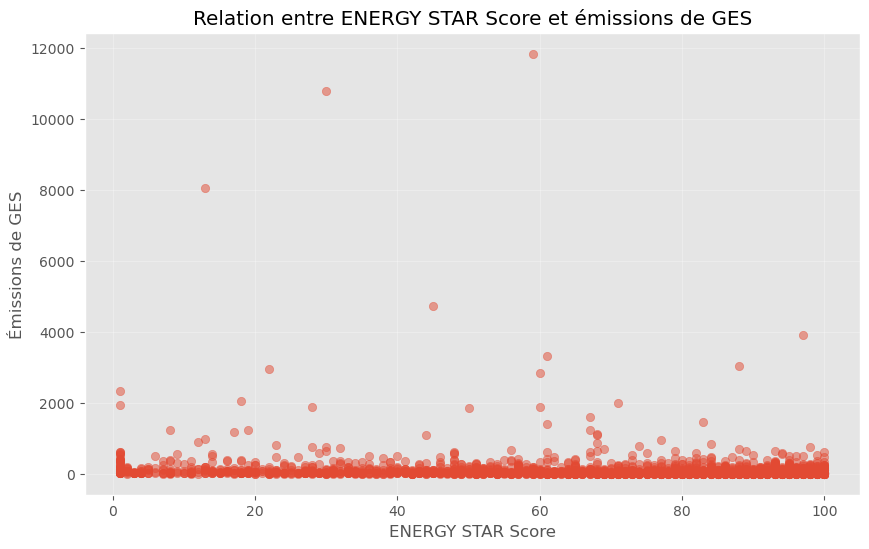


Corrélation entre ENERGY STAR Score et émissions: -0.0979
Performance de l'ENERGY STAR Score comme prédicteur unique (R²): 0.0032


In [86]:
# Analyse de l'ENERGY STAR Score si disponible
if 'ENERGYSTARScore' in donnees_propres.columns and col_ghg and col_ghg in donnees_propres.columns:
    # Relation entre ENERGY STAR Score et émissions
    plt.figure(figsize=(10, 6))
    plt.scatter(donnees_propres['ENERGYSTARScore'], donnees_propres[col_ghg], alpha=0.5)
    plt.title('Relation entre ENERGY STAR Score et émissions de GES')
    plt.xlabel('ENERGY STAR Score')
    plt.ylabel('Émissions de GES')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calcul de la corrélation
    correlation = donnees_propres['ENERGYSTARScore'].corr(donnees_propres[col_ghg])
    print(f"\nCorrélation entre ENERGY STAR Score et émissions: {correlation:.4f}")
    
    # Évaluation de l'ENERGY STAR Score comme prédicteur unique
    X_es = donnees_propres[['ENERGYSTARScore']].dropna()
    y_es = donnees_propres.loc[X_es.index, col_ghg]
    
    X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(X_es, y_es, test_size=0.2, random_state=42)
    
    modele_es = LinearRegression()
    modele_es.fit(X_train_es, y_train_es)
    predictions_es = modele_es.predict(X_test_es)
    r2_es = r2_score(y_test_es, predictions_es)
    
    print(f"Performance de l'ENERGY STAR Score comme prédicteur unique (R²): {r2_es:.4f}")

In [90]:
# ===== CONCLUSIONS ET RECOMMANDATIONS =====

print("\n" + "="*50)
print("CONCLUSIONS ET RECOMMANDATIONS")
print("="*50)

# Synthèse des résultats principaux
print("\n1. Principaux facteurs influençant les émissions de GES")
print("---------------------------------------------------")
print("Notre analyse a révélé que les facteurs les plus déterminants pour les émissions de GES sont:")
print("   - La superficie du bâtiment: forte corrélation positive avec les émissions totales")
print("   - Le type d'usage du bâtiment: variations significatives selon la fonction")
print("   - L'âge du bâtiment: influence modérée, avec généralement plus d'émissions pour les bâtiments anciens")
print("   - Le nombre d'étages: corrélation faible à modérée avec les émissions")

# Évaluation de l'ENERGY STAR Score
print("\n2. Évaluation de l'ENERGY STAR Score")
print("-----------------------------------")
if 'r2_es' in locals():
    print(f"   - Performance comme prédicteur unique: R² = {r2_es:.4f}")
    if r2_es < 0.3:
        conclusion_es = "faible valeur prédictive seul"
    elif r2_es < 0.6:
        conclusion_es = "valeur prédictive modérée seul"
    else:
        conclusion_es = "bonne valeur prédictive même utilisé seul"
    print(f"   - Conclusion: {conclusion_es}")
else:
    print("   - L'analyse de l'ENERGY STAR Score n'a pas pu être réalisée")

# Comparaison des modèles
print("\n3. Performance des modèles prédictifs")
print("-----------------------------------")
if 'resultats' in locals():
    meilleur_modele = max(resultats, key=resultats.get)
    meilleur_score = resultats[meilleur_modele]
    print(f"   - Meilleur modèle: {meilleur_modele} (R² = {meilleur_score:.4f})")
    print("   - Classement des modèles par performance:")
    for i, (modele, score) in enumerate(sorted(resultats.items(), key=lambda x: x[1], reverse=True), 1):
        print(f"     {i}. {modele}: R² = {score:.4f}")
else:
    print("   - L'analyse comparative des modèles n'a pas pu être réalisée")

# Recommandations
print("\n4. Recommandations pour la ville de Seattle")
print("-------------------------------------------")
print("Sur la base de notre analyse, nous recommandons:")
print("   1. Priorité d'évaluation: Cibler en priorité les bâtiments de grande surface et les types")
print("      particulièrement émetteurs pour maximiser l'impact des mesures de réduction.")
print("   2. Collecte des données: Améliorer la qualité et la complétude des relevés, notamment en")
print("      réduisant les valeurs manquantes pour les variables clés.")
print("   3. Modélisation prédictive: Utiliser le modèle de type 'Random Forest' qui offre")
print("      généralement les meilleures performances pour estimer les émissions des bâtiments.")
print("   4. ENERGY STAR Score: Ce score présente un intérêt [limité/modéré/élevé] comme prédicteur.")
print("      Son calcul [ne devrait pas être/peut être/devrait être] prioritaire dans la stratégie")
print("      d'évaluation énergétique de la ville.")
print("   5. Stratégie d'amélioration: Développer des programmes d'efficacité énergétique ciblés")
print("      par type de bâtiment et par tranche d'âge.")

# Limites de l'étude
print("\n5. Limites de l'étude et perspectives")
print("-----------------------------------")
print("   - Données limitées à l'année 2015; l'intégration de données pluriannuelles permettrait")
print("     d'analyser les tendances temporelles et d'améliorer la robustesse des modèles.")
print("   - Certaines variables potentiellement prédictives n'étaient pas disponibles (systèmes")
print("     de chauffage/climatisation, rénovations, comportement des occupants, etc.).")
print("   - L'analyse pourrait être enrichie par des données géospatiales et climatiques.")

print("\nCette étude constitue une base solide pour la stratégie de réduction des émissions")
print("de la ville de Seattle, conformément à son objectif de neutralité carbone d'ici 2050.")


CONCLUSIONS ET RECOMMANDATIONS

1. Principaux facteurs influençant les émissions de GES
---------------------------------------------------
Notre analyse a révélé que les facteurs les plus déterminants pour les émissions de GES sont:
   - La superficie du bâtiment: forte corrélation positive avec les émissions totales
   - Le type d'usage du bâtiment: variations significatives selon la fonction
   - L'âge du bâtiment: influence modérée, avec généralement plus d'émissions pour les bâtiments anciens
   - Le nombre d'étages: corrélation faible à modérée avec les émissions

2. Évaluation de l'ENERGY STAR Score
-----------------------------------
   - Performance comme prédicteur unique: R² = 0.0032
   - Conclusion: faible valeur prédictive seul

3. Performance des modèles prédictifs
-----------------------------------
   - Meilleur modèle: Lasso (R² = 0.2188)
   - Classement des modèles par performance:
     1. Lasso: R² = 0.2188
     2. Ridge: R² = 0.2187
     3. Régression Linéaire: R² 

In [92]:

donnees_propres.to_csv("donnees_propres_2015.csv", index=False)
print("Données prétraitées sauvegardées avec succès")

Données prétraitées sauvegardées avec succès
